## Data exploration
In this notebook, we will explore a bit the provided datasets.

### Provided datasets and loading methods
Let's check what we have under our `datasets` directory.
Same as before, we use the `os` package.
You should see two different [HDF5] files:
* `dlssus-rf-dataset.h5`
* `dlssus-rf-testset.h5`

[hdf5]: https://support.hdfgroup.org/HDF5/


In [1]:
import os
base_dir = os.path.join('/floyd', 'input', 'dlssus')
data_dir = os.path.join(base_dir, 'datasets')
for f in os.listdir(data_dir):
    print(f)

dlssus-rf-dataset.h5
dlssus-rf-testset.h5


Let's have a look into the `dlssus-rf-dataset.h5` first.
For this, we provide some utilities in the `utils/dataset.py` module that can
be imported as follows.


In [2]:
from utils.dataset import load_dataset, get_dataset_axes, get_dataset_stats

The method `load_dataset` allows to load both `LQ` and `HQ` image pairs.
Let's load `50` image pairs and check at the shape of the returned NumPy
arrays.


In [3]:
dataset_size = 50
dataset_path = os.path.join(data_dir, 'dlssus-rf-dataset.h5')
data_lq, data_hq = load_dataset(path=dataset_path, size=dataset_size)
print('LQ dataset shape:', data_lq.shape)
print('HQ dataset shape:', data_hq.shape)

LQ dataset shape: (50, 256, 512)
HQ dataset shape: (50, 256, 512)


Both arrays are composed of 3 dimensions, namely image-pair number,
sample number in the lateral dimension (`x`) and sample number in the axial
dimension (`z`).


The method `get_dataset_axes` allows to get the image axes, namely the
cartesian grid onto which the ultrasound images have been reconstructed.
Once loaded, we can check their respective sizes and control they match the
shape of the corresponding images.


In [4]:
image_axes = get_dataset_axes(path=dataset_path)
x_axis, z_axis = image_axes  # Unpack axes

print('x-axis size: {}'.format(x_axis.size))
print('z-axis size: {}'.format(z_axis.size))

x-axis size: 256
z-axis size: 512


The method `get_dataset_stats_` allows to get the pre-computed dataset
statistics, namely mean and standard deviation, which will be used later for
training.
You may ask yourself why not compute it directly using NumPy's functions, i.e.
`np.std()` and `np.mean()`?
Simply because for the purpose of the spring school, the dataset has been
cropped and drastically reduced.
Hence we wanted to keep the statistics of the original dataset.
Just for your info, the initial dataset is about 250GB.


In [5]:
stats_lq, stats_hq = get_dataset_stats(path=dataset_path)
mean_lq, std_lq = stats_lq  # unpack mean and std
mean_hq, std_hq = stats_hq  # unpack mean and std
print('LQ mean and std:', stats_lq)
print('HQ mean and std:', stats_hq)

LQ mean and std: (3.1914935e-12, 2.0681408e-07)
HQ mean and std: (3.857374e-12, 1.3822439e-06)


Quick question: do you have an idea on why the images are (almost) zero-mean?
If not just continue further :).


### Plot some randomly selected image pairs
We can now have a closer look to some (random) image pairs within the dataset.
Let's first pick randomly 4 image pairs using NumPy's pseudorandom number
generator.

**Notes:**
* We use a `seed` number here.
This is very useful when you want your random experiment to be reproducible.
* You may of course use another `seed` number
(still `42` may be your [answer][42answer]).

[42answer]: https://en.wikipedia.org/wiki/42_(number)


In [6]:
import numpy as np  # obviously we need to import numpy
seed = 42
# Create the pseudorandom number generator (prng)
prng = np.random.RandomState(seed=seed)
# Generate random indexes within the range of the loaded dataset size
inds = prng.randint(low=0, high=dataset_size, size=4)
# Slice the numpy arrays
images_lq = data_lq[inds]
images_hq = data_hq[inds]
# We can confirm we have 4 image pairs (first dimension)
print('LQ images shape:', images_lq.shape)
print('HQ images shape:', images_hq.shape)

LQ images shape: (4, 256, 512)
HQ images shape: (4, 256, 512)


In order to simplify plotting operations (which can sometimes be quite
cumbersome) we provide a `plot_image_sequences` methods that can be imported
from the `utils.plot` module.
See below how to use it on the selected 4 image pairs.
We can associate the corresponding name sequence that will be used as
sub-figure titles.


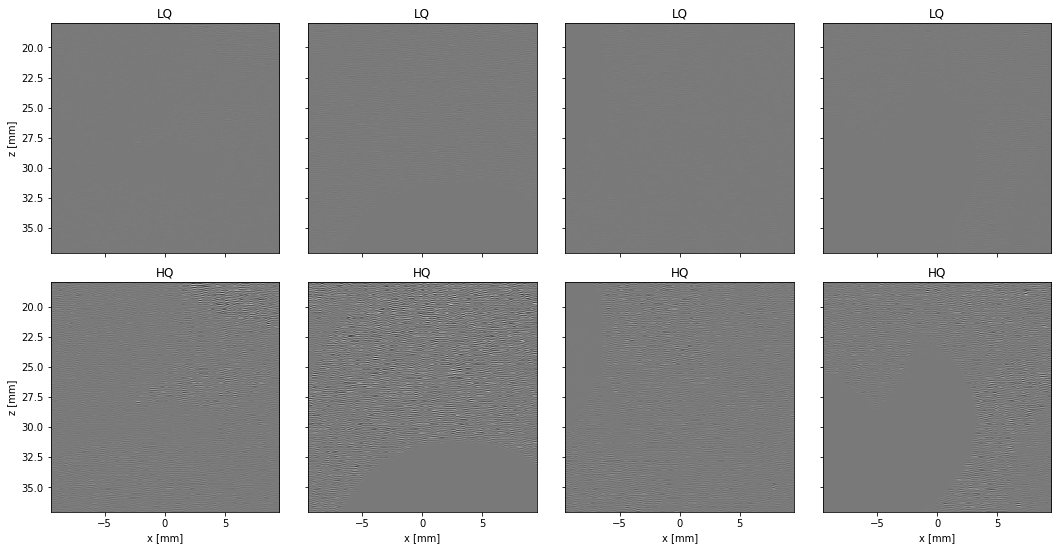

In [9]:
from utils.plot import plot_image_sequences
name_seq = ('LQ', 'HQ')
plot_image_sequences(
    image_seq=(images_lq, images_hq), name_seq=name_seq,
    image_axes=image_axes
)

So now you may ask yoursefl what are these images?!
And why don't they look like the nice baby image from the introduction?!

Well ultrasound images are initially [radio-frequency][rf] (RF) images
that require some post-processing to be displayed to "humans".

And for those familiar with RF signals (or those who invested some time
reading the [wikipedia article][rf], they are zero-mean signals
(which should answer the question asked few cells above).

[rf]: https://en.wikipedia.org/wiki/Radio_frequency


### Post-processing before display
In order to display typical ultrasound image, we will have to carry two
important post-processing steps in order to obtain what is commonly called
a B-mode image:
1. [Envelope detection][envelope]
1. [Dynamic range compression][compression]

Please implement these two post-processing techniques to display the above
images properly.

[envelope]: https://en.wikipedia.org/wiki/Envelope_detector
[compression]: https://en.wikipedia.org/wiki/Dynamic_range_compression


Nonono, just kidding :)!
We got your back with a `convert_to_bmode` method accessible from the
`utils.signal` module.
Let's convert RF images to B-mode images and plot the result.

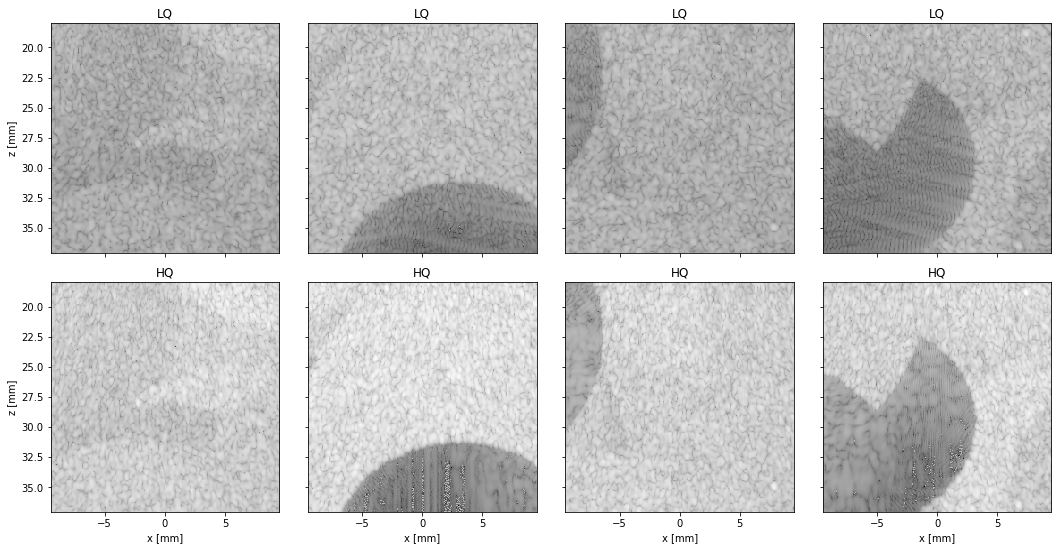

In [10]:
from utils.signal import convert_to_bmode
bmodes_lq = convert_to_bmode(images_lq)
bmodes_hq = convert_to_bmode(images_hq)
plot_image_sequences(
    image_seq=(bmodes_lq, bmodes_hq), name_seq=name_seq,
    image_axes=image_axes
)

What??? We are still far from the baby image!
Well, we need to scale the RF image before compressing it and plot it within
the proper dynamic range...
To do so, you can use the `normalize_data` method accessible from the
`utils.signal` module before converting the RF image to B-mode.

**Note:** the normalization (zero-mean, standard deviation one)
will actually be useful to help with the training process too (great!).


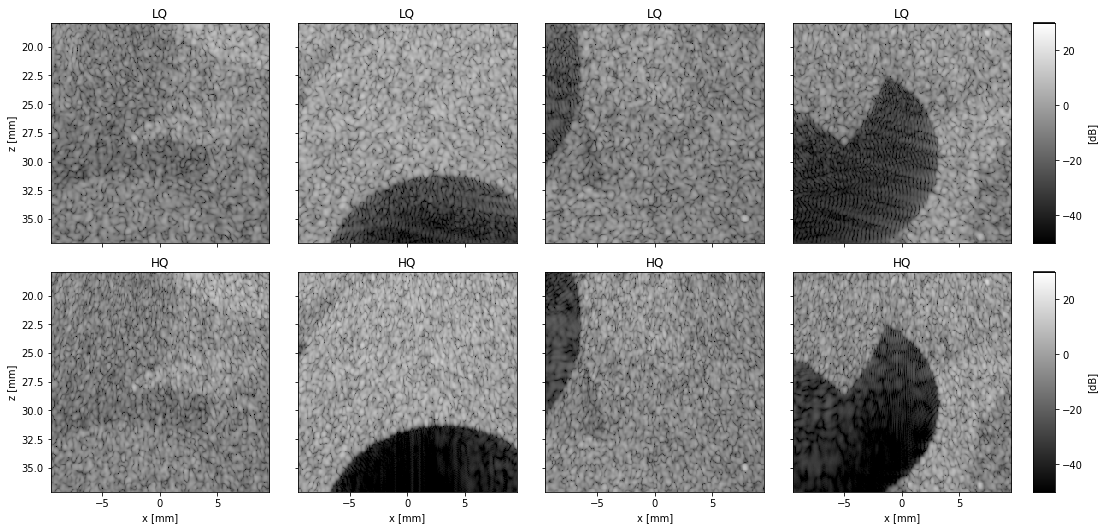

In [11]:
from utils.signal import normalize_data
data_range = (-50, 30)  # in dB!
# Normalize the data
images_lq_norm = normalize_data(data=images_lq, stats=stats_lq)
images_hq_norm = normalize_data(data=images_hq, stats=stats_hq)
# Convert again to B-mode
bmodes_lq = convert_to_bmode(images_lq_norm)
bmodes_hq = convert_to_bmode(images_hq_norm)
# Plot
plot_image_sequences(
    image_seq=(bmodes_lq, bmodes_hq), name_seq=name_seq,
    image_axes=image_axes, data_range=data_range, colorbar=True
)


So now we are talking :)!
Again just kidding, we are looking at randomly generated numerical phantoms,
which was one the most important part of the data generation process we
implemented to achieve such image reconstruction performances.

Let's just have a look at the test set that has actually been designed
for visualization purposes :).


### Test set
The procedure to display the test set set is similar.
The name of the test set is `dlssus-rf-testset.h5` and is located under the
same directory.

**Notes**:
* We already normalized the test set.
* You can check this by loading the stats of the test set as well
(if interested).


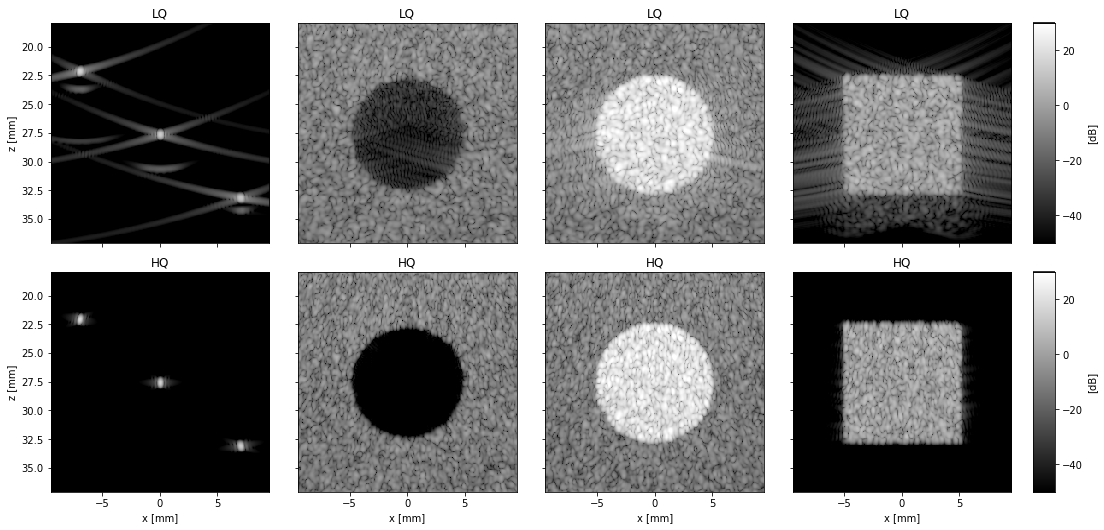

In [12]:
# Load test set
testset_path = os.path.join(data_dir, 'dlssus-rf-testset.h5')
test_lq, test_hq = load_dataset(path=testset_path)
# Convert to B-mode
test_bm_lq = convert_to_bmode(test_lq)
test_bm_hq = convert_to_bmode(test_hq)
# Plot
plot_image_sequences(
    image_seq=(test_bm_lq, test_bm_hq),
    image_axes=image_axes, name_seq=name_seq,
    data_range=data_range, colorbar=True
)

As already highlighted in the introduction, we can see typical ultrasound image
artifacts and enhancements, namely:
* side lobes are drastically reduced in HQ -> better contrast
* ghost artifacts (clearly visible on the left-most image pair below each
point) disapear in HQ images.
* The lateral resolution is slightly improved (tigher main lobe) in HQ.
* No grating lobe present in these images
(but most of the training pairs have).

### Done? Just head to the [next notebook][next] for the first training.

[next]: dlssus_first_training.ipynb

Or you can go back to the [outline].

[outline]: dlssus_main.ipynb
